<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/henry/HenryTaGSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Preparation

###Data Loading and observation

In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the data from the drive
id = '1E07PMf68jMo-rULzHfE_q7chqgaYGsXp'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AIDS700.zip')
!ls

AIDS700.zip  sample_data


In [2]:
#if AIDS700nef exist do not run this part
#removing the dialog
%%capture
#unzip the file
!unzip AIDS700.zip

In [3]:
#visualise the first network data: 1011.gexf
import networkx as nx
import matplotlib.pyplot as plt
import random

#read the 1011.gexf
Graph = nx.read_gexf('AIDS700nef/train/4.gexf',version='1.2draft')


In [4]:
Graph.edges.data()
edgesdict={}
for n1,n2,attr in Graph.edges.data():
  edgesdict[(n1,n2)]=attr['valence']
edgesdict

{('7', '3'): 2,
 ('3', '1'): 1,
 ('3', '8'): 2,
 ('3', '9'): 1,
 ('5', '2'): 2,
 ('6', '2'): 1,
 ('1', '0'): 1,
 ('0', '2'): 1,
 ('4', '2'): 2}

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

G=Graph
def draw_graph(G):
  pos=nx.spring_layout(G ,seed=42,scale=2)
  edgelist=G.edges
  edge_labels = nx.get_edge_attributes(G, "valence")
  node_labels = nx.get_node_attributes(G, "type")

  nx.draw_networkx_nodes(G, pos, node_size=700)
  nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)
  nx.draw_networkx_labels(G, pos,labels=node_labels, font_size=20, font_family="sans-serif")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)
def draw_graph_id(G):
  pos=nx.spring_layout(G ,seed=42,scale=2)
  edgelist=G.edges
  edge_labels = nx.get_edge_attributes(G, "valence")

  nx.draw_networkx_nodes(G, pos, node_size=700)
  nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)
  nx.draw_networkx_labels(G, pos,  font_size=20, font_family="sans-serif")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)


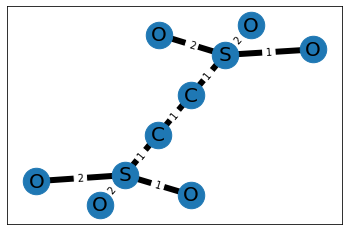

In [6]:
draw_graph(G)

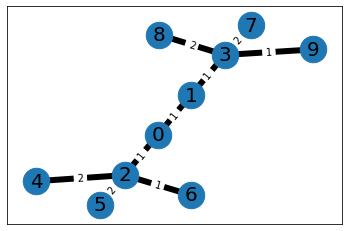

In [7]:
draw_graph_id(G)

### Graph Pair Generator

Relabel node list: {'9': {'type': 'S'}}
[10]
Delete edge: [('7', '3')]
Relable edge: {('4', '2'): {'valence': 1}}
Add edge: [('4', 10), ('5', '6')]
{'NR': 1, 'NID': 1, 'ER': 1, 'EID': 3}


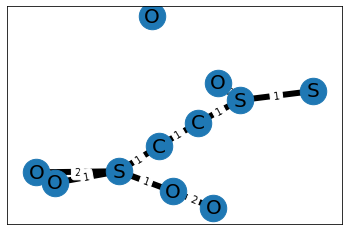

In [8]:
def graphPairGenerator(Graph,targetGEV):
  NR=targetGEV['NR']
  NID=targetGEV['NID']
  ER=targetGEV['ER']
  EID=targetGEV['EID']
  
  nodeList= list(Graph.nodes)
  edgeList= list(Graph.edges)

  # set limit of relabeling
  NodeDataView=Graph.nodes.data()
  if NR>len(nodeList):
    NR=len(nodeList)
  EdgeView=Graph.edges 
  if ER>len(edgeList):
    ER=len(edgeList)


  newGraph=Graph.copy()
  nodeLabels=set(nx.get_node_attributes(newGraph, "type").values())
  edgeLabels=set(nx.get_edge_attributes(newGraph, "valence").values())

  def NodeRelabel(newGraph,NR):
    relabedNode=[]

    relabelDict={}
    for i in range(NR):
      nodeToBeRebel=random.choice(list(newGraph.nodes))
      while(nodeToBeRebel in relabedNode ):
        nodeToBeRebel=random.choice(list(newGraph.nodes))
      relabedNode.append(nodeToBeRebel)

      relabelDict[nodeToBeRebel]={}
      newLabel=random.choice(list(nodeLabels))
      while(newLabel ==NodeDataView[nodeToBeRebel]["type"] ):
        newLabel=random.choice(list(nodeLabels))
      relabelDict[nodeToBeRebel]['type']=newLabel
    nx.set_node_attributes(newGraph, relabelDict)
    print('Relabel node list:',relabelDict)
    return newGraph

  def NodeInserted(newGraph,NID):
    newNode=[]
    for i in range(NID):
      label=random.choice(list(nodeLabels))
      newGraph.add_node(i+len(nodeList),type=label)
      newNode.append(i+len(nodeList))
    print(newNode)
    return newGraph

  def EdgeDelete(newGraph,EID):
    toDel=0
    if EID>0:
      toDel=random.choice(list(range(EID)))
    deletedEdge=[]
    for i in range(toDel):
      e=random.choice(list(newGraph.edges))
      newGraph.remove_edge(*e)
      deletedEdge.append(e)
    print('Delete edge:',deletedEdge)
    return newGraph,deletedEdge,toDel

  def EdgeRelabel(newGraph,ER):
    relabedEdge=[]

    relabelDict={}
    for i in range(ER):
      edgeToBeRebel=random.choice(list(newGraph.edges))
      while(edgeToBeRebel in relabedEdge ):
        edgeToBeRebel=random.choice(list(newGraph.edges))
      relabedEdge.append(edgeToBeRebel)

      relabelDict[edgeToBeRebel]={}
      newLabel=random.choice(list(edgeLabels))
      while(newLabel ==nx.get_edge_attributes(G,'valence')[edgeToBeRebel] ):
        newLabel=random.choice(list(edgeLabels))
      relabelDict[edgeToBeRebel]['valence']=newLabel
    nx.set_edge_attributes(newGraph, relabelDict)
    print('Relable edge:',relabelDict)
    return newGraph

  def EdgeInsert(newGraph,toInsert,deletedEdge): 
    newEdges=[]
    for i in range(toInsert):
      e=random.choice(list(newGraph.edges))

      n1,n2=random.choice(list(newGraph.nodes)),random.choice(list(newGraph.nodes))
      #random select 2 node agian if edge has already existed/the edge is deleted in delete rpocess
      while(n1==n2 or (n1,n2) in list(Graph.edges) or (n2,n1) in list(Graph.edges)or (n1,n2) in deletedEdge or (n2,n1) in deletedEdge):
        n1,n2=random.choice(list(newGraph.nodes)),random.choice(list(newGraph.nodes))
      newGraph.add_edge(n1,n2,valence=random.choice(list(edgeLabels)))
      newEdges.append((n1,n2))
    print('Add edge:',newEdges)
    return newGraph 

  newGraph = NodeRelabel(newGraph,NR)
  newGraph = NodeInserted(newGraph,NID)
  newGraph,deletedEdge,toDel = EdgeDelete(newGraph,EID) 
  newGraph = EdgeRelabel(newGraph,ER) 
  newGraph = EdgeInsert(newGraph,EID-toDel,deletedEdge) 
  
  finalGEV={'NR':NR,'NID':NID,'ER':ER,'EID':EID}
  return Graph,newGraph,finalGEV
targetGEV={'NR':1,'NID':1,'ER':1,'EID':3}

(Graph,newGraph,GEV)=graphPairGenerator(Graph,targetGEV)
print(GEV)
draw_graph(newGraph)

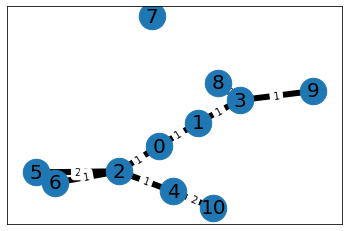

In [9]:

draw_graph_id(newGraph)

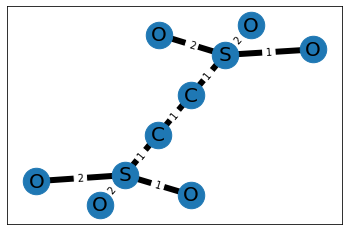

In [10]:

draw_graph(Graph)

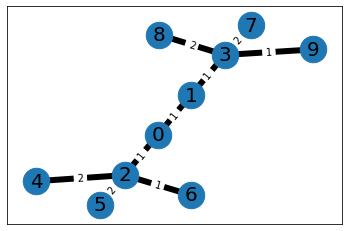

In [11]:
draw_graph_id(Graph)